1. Descomprimir dataset de kaggle

In [ ]:
# Descomprimimos todo el contenido del ZIP en /content/garbage_dataset/
!unzip -q /content/archive.zip -d /content/proyecto_integrador/

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


2. Importar librerias necesarias

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

3. Definir transformaciones (preprocesamiento)

In [ ]:
IMG_SIZE = 224

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "val": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    "test": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
}

4. Leer los archivos TXT de splits (train/val/test)

In [ ]:
def cargar_lista_split(txt_path, root_folder):
    """
    Lee líneas del tipo: 'paper305.jpg 2'
    Busca la imagen dentro de todas las carpetas de clases.
    Devuelve (ruta_completa, etiqueta)
    """
    samples = []

    # Obtener carpetas de imagenes: ['glass', 'metal', 'plastic', 'trash', 'cardboard', 'paper']
    clases = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    with open(txt_path, "r") as f:
        for line in f:
            line = line.strip()
            if line == "":
                continue
            try:
                filename, class_idx_str = line.split()
                class_idx = int(class_idx_str)

                # Buscar la imagen dentro de las subcarpetas
                found = False
                for clase_folder in clases:
                    candidate_path = os.path.join(root_folder, clase_folder, filename)
                    if os.path.exists(candidate_path):
                        samples.append((candidate_path, class_idx))
                        found = True
                        break
                if not found:
                    print(f"[ADVERTENCIA] No se encontró la imagen: {filename}")

            except ValueError:
                print(f"[ERROR] Línea malformada: {line}")
                continue

    return samples

# 4.1. Definir rutas con base en proyecto_integrador
BASE_IMG_FOLDER = "/content/proyecto_integrador/Garbage classification/Garbage classification"

train_txt = "/content/proyecto_integrador/one-indexed-files-notrash_train.txt"
val_txt   = "/content/proyecto_integrador/one-indexed-files-notrash_val.txt"
test_txt  = "/content/proyecto_integrador/one-indexed-files-notrash_test.txt"

# 4.2. Cargar listas de (ruta_imagen, etiqueta)
train_samples = cargar_lista_split(train_txt, BASE_IMG_FOLDER)
val_samples   = cargar_lista_split(val_txt,   BASE_IMG_FOLDER)
test_samples  = cargar_lista_split(test_txt,  BASE_IMG_FOLDER)

print(f"Cantidad de samples en TRAIN: {len(train_samples)}")
print(f"Cantidad de samples en VAL:   {len(val_samples)}")
print(f"Cantidad de samples en TEST:  {len(test_samples)}")


Cantidad de samples en TRAIN: 1768
Cantidad de samples en VAL:   328
Cantidad de samples en TEST:  431


5. Crear la clase Dataset personalizada en PyTorch

In [ ]:
class GarbageDataset(Dataset):
    def __init__(self, samples, transform=None):
        """
        samples: lista de tuplas (ruta_imagen, etiqueta)
        transform: torchvision.transforms a aplicar
        """
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # Abrimos con PIL y forzamos modo RGB
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

6. Instanciar los datasets y los dataloaders

6.1. Crear objetos de tipo GarbageDataset

In [ ]:
dataset_train = GarbageDataset(train_samples, transform=data_transforms["train"])
dataset_val   = GarbageDataset(val_samples,   transform=data_transforms["val"])
dataset_test  = GarbageDataset(test_samples,  transform=data_transforms["test"])

6.2. Definir los DataLoaders

In [ ]:
BATCH_SIZE = 32

dataloader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [22]:
# Mostrar la forma del primer batch de entrenamiento
batch_imgs, batch_labels = next(iter(dataloader_train))

print("Shape del batch de imágenes:", batch_imgs.shape)   # Debería ser [32, 3, 224, 224]
print("Shape del batch de etiquetas:", batch_labels.shape)  # Debería ser [32]

Shape del batch de imágenes: torch.Size([32, 3, 224, 224])
Shape del batch de etiquetas: torch.Size([32])


7. Verificar visualmente algunas imágenes procesadas

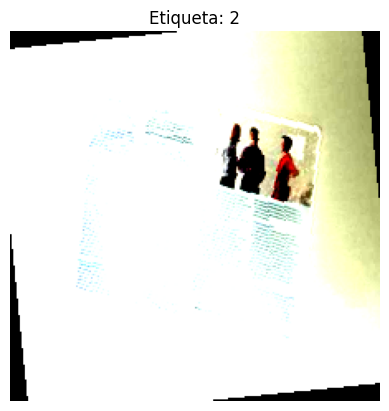

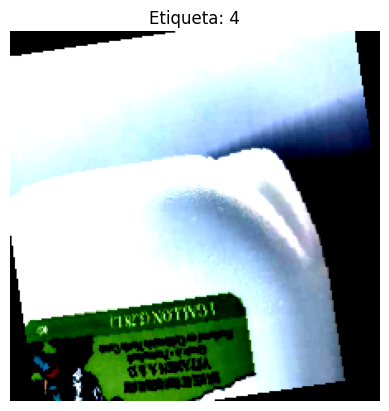

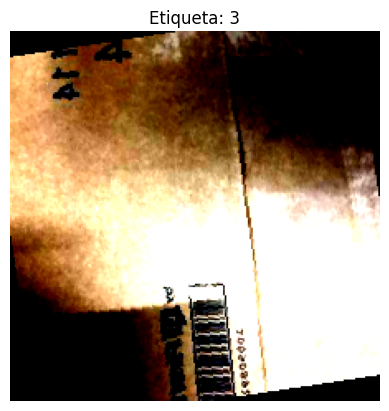

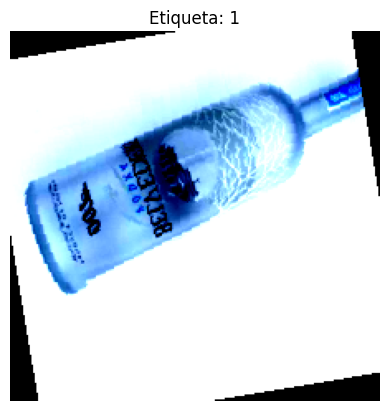

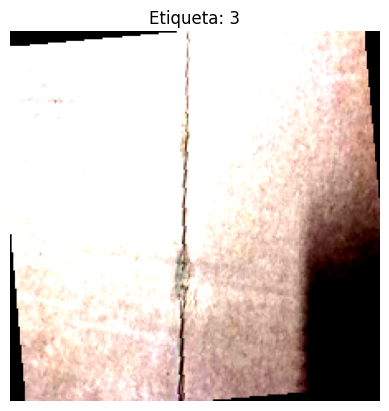

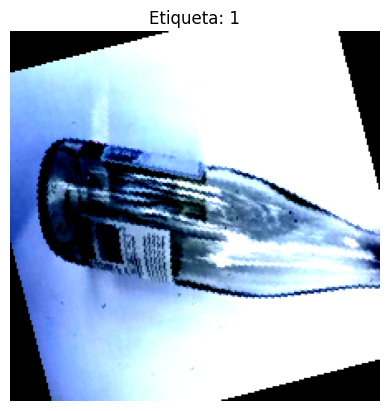

In [29]:
# Obtener el primer batch
batch_imgs, batch_labels = next(iter(dataloader_train))

# Mostrar las primeras 6 img del batch
for i in range(6):
    img = batch_imgs[i].permute(1, 2, 0).numpy() # CHW -> HWC | tensor -> array | para matplotlib
    img = img.clip(0, 1)  # Si está normalizado, puede haber valores fuera de rango
    label = batch_labels[i]

    plt.imshow(img)
    plt.title(f"Etiqueta: {label}")
    plt.axis("off")
    plt.show()

